In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Persiapan Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

documents_folder = "/content/drive/My Drive/Semester 2/Deep Learning/"
# Use pd.read_json to read data from the JSON file
df = pd.read_csv(documents_folder+"dataset_kamus_alay.csv")
print(len(df))
df.head()

4748


,slang,formal
0,Akoh lagi syedih,Aku sedang sedih
1,Gw males banget ngerjain tugas ini,Saya malas sekali mengerjakan tugas ini
2,Elo mau ikut nongki gak?,Kamu mau ikut nongkrong tidak?
3,Nggak usah lebay deh,Tidak usah berlebihan
4,Udah kelar belom kerjaan lo?,Sudah selesai belum pekerjaanmu?


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4748 entries, 0 to 4747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   slang   4748 non-null   object
 1   formal  4748 non-null   object
dtypes: object(2)
memory usage: 74.3+ KB


In [5]:
# Pisahkan input dan target
# Preprocessing dasar
df['slang'] = df['slang'].str.lower().str.replace('[^\w\s]', '', regex=True) # Added regex=True
df['formal'] = df['formal'].str.lower().str.replace('[^\w\s]', '', regex=True) # Added regex=True

raw_src = df['slang']
# Add start and end tokens to the target sentences
raw_tgt = '[start] ' + df['formal'] + ' [end]'


# Split train-validation
src_train, src_val, tgt_train, tgt_val = train_test_split(
    raw_src, raw_tgt, test_size=0.2, random_state=42)

print(len(src_train))
print(len(src_val))

3798
950


#Preprocessing & Tokenisasi

In [6]:
# Hyperparameter
MAX_SEQ_LENGTH = 64
VOCAB_SIZE = 500
BATCH_SIZE = 1
EPOCHS = 20

In [7]:
# Buat tokenizer
# Ensure `standardize` does not remove our added [start] and [end] tokens
# Also increase MAX_SEQ_LENGTH for the target to accommodate [start] and [end]
src_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation', # This will remove our [start] and [end] if not careful
    output_sequence_length=MAX_SEQ_LENGTH
)

# A custom standardization function to keep [start] and [end]
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    # Remove punctuation except for []
    cleaned_text = tf.strings.regex_replace(lowercase, '[^\w\s\[\]]', '')
    return cleaned_text

tgt_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=custom_standardization, # Use custom standardization
    output_sequence_length=MAX_SEQ_LENGTH + 2 # +2 for [start] and [end]
)


# Adapt tokenizer
src_tokenizer.adapt(src_train)
tgt_tokenizer.adapt(tgt_train)

# Fungsi preprocessing
def preprocess_text(src, tgt):
    src = src_tokenizer(src)
    # The target includes [start] and [end].
    # tgt_in should be [start]...token_n, tgt_out should be token_1...[end]
    tgt_tokens = tgt_tokenizer(tgt)
    tgt_in = tgt_tokens[:, :-1] # Exclude the last token ([end])
    tgt_out = tgt_tokens[:, 1:] # Exclude the first token ([start])
    return (src, tgt_in), tgt_out

# Buat dataset
train_dataset = tf.data.Dataset.from_tensor_slices((src_train, tgt_train))
# Apply batch before map
train_dataset = train_dataset.batch(BATCH_SIZE).map(preprocess_text).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((src_val, tgt_val))
# Apply batch before map
val_dataset = val_dataset.batch(BATCH_SIZE).map(preprocess_text).prefetch(tf.data.AUTOTUNE)

# Check if [start] and [end] are in the vocabulary
print("[start] in tgt_vocab:", '[start]' in tgt_tokenizer.get_vocabulary())
print("[end] in tgt_vocab:", '[end]' in tgt_tokenizer.get_vocabulary())
print("Sample of tgt_train:", tgt_train.head().values)

[start] in tgt_vocab: True
[end] in tgt_vocab: True
Sample of tgt_train: ['[start] kamu selalu membuat aku lengkap sekali [end]'
 '[start] jangan lupa tersenyum ya [end]'
 '[start] ia sungguh mengapresiasi setiap perjuangan dan pengorbanan yang telah engkau curahkan segenap hati [end]'
 '[start] kamu kemarin ke mana [end]' '[start] saya bangga padamu [end]']


#Arsitektur Model

In [8]:
import tensorflow as tf
import numpy as np

# ===========================================
# 1. Multi-Head Attention (Kelas Terpisah)
# ===========================================
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = tf.shape(q)[0]

        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        # Scaled Dot-Product Attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            # Perhatikan penambahan mask yang di-broadcast
            scaled_attention += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention, axis=-1)
        output = tf.matmul(attention_weights, v)

        # Concatenate Heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))

        return self.dense(output)

# ===========================================
# 2. Encoder (Kelas Terpisah)
# ===========================================
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    # training dan mask adalah parameter untuk call
    def call(self, x, training=True, mask=None): # Set training to True by default
        # Self Attention
        attn_output = self.mha(x, x, x, mask) # x, x, x untuk self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        # Feed Forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        # Inisialisasi PositionalEncoding dengan 'position' dan 'd_model'
        self.pos_encoding = PositionalEncoding(pe_input, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    # Add training as keyword argument for consistency
    def call(self, x, training=True, mask=None): # Set training to True by default
        seq_len = tf.shape(x)[1]

        # Penambahan positional encoding ke embedding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Skalakan embedding
        x = self.pos_encoding(x) # Tambahkan positional encoding
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            # Pass training as keyword argument to EncoderLayer
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x # Output dari encoder adalah representasi kaya konteks

# ===========================================
# 3. Decoder (Kelas Terpisah)
# ===========================================
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads) # Masked self-attention
        self.mha2 = MultiHeadAttention(d_model, num_heads) # Encoder-decoder attention
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    # training, look_ahead_mask, dan padding_mask adalah parameter untuk call
    def call(self, x, enc_output, training=True, look_ahead_mask=None, padding_mask=None): # Set training to True by default
        # Masked Self Attention (menggunakan look_ahead_mask)
        attn1 = self.mha1(x, x, x, look_ahead_mask) # query, key, value dari output decoder sebelumnya
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x) # Add & Norm

        # Encoder-Decoder Attention (menggunakan padding_mask dari encoder)
        # query dari output masked self-attention, key dan value dari output encoder
        attn2 = self.mha2(
            out1, enc_output, enc_output, padding_mask # perhatikan urutan q, k, v
        )
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1) # Add & Norm

        # Feed Forward
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(ffn_output + out2) # Add & Norm

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        # Inisialisasi PositionalEncoding dengan 'position' dan 'd_model'
        self.pos_encoding = PositionalEncoding(pe_target, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    # Add training as keyword argument for consistency
    def call(self, x, enc_output, training=True, look_ahead_mask=None, padding_mask=None): # Set training to True by default
        seq_len = tf.shape(x)[1]

        # Penambahan positional encoding ke embedding
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Skalakan embedding
        x = self.pos_encoding(x) # Tambahkan positional encoding
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            # Masukkan kedua mask ke setiap decoder layer, pass training as keyword argument
            x = self.dec_layers[i](x, enc_output, training=training,
                                  look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

        return x # Output dari decoder stack

# ===========================================
# 4. Positional Encoding
# ===========================================
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def positional_encoding(self, position, d_model):
        # Menghitung sudut radian untuk setiap posisi dan setiap dimensi
        angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)//2) / np.float32(d_model)))

        # Terapkan sin pada posisi genap
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # Terapkan cos pada posisi ganjil
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        # Tambahkan dimensi batch dan ubah ke tipe float32 Tensor
        return tf.cast(angle_rads[np.newaxis, ...], tf.float32)

    # Input x memiliki shape (batch_size, seq_len, d_model)
    def call(self, x):
        # Tambahkan positional encoding ke input
        # Ambil positional encoding hanya sepanjang seq_len input
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ===========================================
# 5. Transformer Model Utama
# ===========================================
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super().__init__()
        # Inisialisasi encoder dan decoder, berikan pe_input dan pe_target
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        # Layer output akhir
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    # Metode untuk membuat mask
    def create_masks(self, src, tgt):
        # Mask padding untuk encoder (berdasarkan src). Digunakan di encoder self-attention
        enc_padding_mask = tf.cast(tf.math.equal(src, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

        # Mask padding untuk decoder (berdasarkan tgt). Digunakan di decoder self-attention dan encoder-decoder attention
        # Catatan: Asumsikan nilai padding adalah 0
        dec_padding_mask = tf.cast(tf.math.equal(tgt, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

        # Mask look-ahead untuk decoder (untuk masked self-attention pertama di decoder)
        look_ahead_mask = 1 - tf.linalg.band_part(
            tf.ones((tf.shape(tgt)[1], tf.shape(tgt)[1])), -1, 0)

        # Gabungkan mask look-ahead dan mask padding untuk masked self-attention di decoder
        combined_mask = tf.maximum(dec_padding_mask, look_ahead_mask)

        # Mask padding untuk encoder-decoder attention (berdasarkan src). Digunakan di MHA kedua decoder
        # Mask ini memastikan decoder tidak memperhatikan token padding di input encoder
        encoder_decoder_padding_mask = tf.cast(tf.math.equal(src, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]


        # Kembalikan tiga jenis mask yang dibutuhkan
        return enc_padding_mask, combined_mask, encoder_decoder_padding_mask

    # Metode call untuk forward pass
    def call(self, inputs, training=True):
        src, tgt = inputs
        # Buat semua mask yang dibutuhkan
        enc_padding_mask, combined_mask, encoder_decoder_padding_mask = self.create_masks(src, tgt)

        # Forward pass melalui encoder
        # Pass training as keyword argument
        enc_output = self.encoder(src, training=training, mask=enc_padding_mask)

        # Forward pass melalui decoder
        # Pass training as keyword argument
        dec_output = self.decoder(
            tgt, enc_output, training=training,
            look_ahead_mask=combined_mask, # Mask gabungan untuk masked self-attention
            padding_mask=encoder_decoder_padding_mask # Mask padding untuk encoder-decoder attention
        )

        # Layer output akhir
        final_output = self.final_layer(dec_output)

        return final_output # Output akhir adalah probabilitas distribusi kata target

#Training & Evaluasi

In [9]:
# Hyperparameter Eksperiman 1
NUM_LAYERS = 2
D_MODEL = 64
NUM_HEADS = 4
DFF = 256
INPUT_VOCAB_SIZE = 500
TARGET_VOCAB_SIZE = 500
MAX_POSITION_ENCODING = 500

# Inisialisasi model
transformer = Transformer(
    NUM_LAYERS, D_MODEL, NUM_HEADS, DFF,
    INPUT_VOCAB_SIZE, TARGET_VOCAB_SIZE,
    MAX_POSITION_ENCODING, MAX_POSITION_ENCODING
)
# Kompilasi model
transformer.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [10]:
# Callback untuk early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

# Training
history = transformer.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stop]
)

Epoch 1/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 68s 9ms/step - accuracy: 0.8992 - loss: 0.6853 - val_accuracy: 0.9239 - val_loss: 0.4047
Epoch 2/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.9247 - loss: 0.3940 - val_accuracy: 0.9328 - val_loss: 0.3388
Epoch 3/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9324 - loss: 0.3295 - val_accuracy: 0.9378 - val_loss: 0.3039
Epoch 4/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9395 - loss: 0.2819 - val_accuracy: 0.9417 - val_loss: 0.2826
Epoch 5/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 35s 9ms/step - accuracy: 0.9438 - loss: 0.2530 - val_accuracy: 0.9451 - val_loss: 0.2628
Epoch 6/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9472 - loss: 0.2306 - val_accuracy: 0.9466 - val_loss: 0.2561
Epoch 7/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.9503 - loss: 0.2144 - val_accuracy: 0.9489 - val_loss: 0.2429
Epoch 8/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9528 - loss: 0

In [11]:
# Hyperparameter (Contoh untuk Eksperimen 2)
NUM_LAYERS = 2
D_MODEL_2 = 32  # Diubah
NUM_HEADS_2 = 2  # Diubah
DFF = 256      # Tetap
INPUT_VOCAB_SIZE = 500
TARGET_VOCAB_SIZE = 500
MAX_POSITION_ENCODING = 500

# Inisialisasi model
transformer2 = Transformer(
    NUM_LAYERS, D_MODEL_2, NUM_HEADS_2, DFF,
    INPUT_VOCAB_SIZE, TARGET_VOCAB_SIZE,
    MAX_POSITION_ENCODING, MAX_POSITION_ENCODING
)

# Kompilasi model
transformer2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# Training
history2 = transformer2.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stop]
)

Epoch 1/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 67s 9ms/step - accuracy: 0.8957 - loss: 0.8401 - val_accuracy: 0.9219 - val_loss: 0.4355
Epoch 2/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.9229 - loss: 0.4195 - val_accuracy: 0.9328 - val_loss: 0.3503
Epoch 3/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.9325 - loss: 0.3441 - val_accuracy: 0.9405 - val_loss: 0.3043
Epoch 4/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.9400 - loss: 0.2937 - val_accuracy: 0.9469 - val_loss: 0.2663
Epoch 5/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.9450 - loss: 0.2583 - val_accuracy: 0.9501 - val_loss: 0.2473
Epoch 6/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.9499 - loss: 0.2327 - val_accuracy: 0.9527 - val_loss: 0.2332
Epoch 7/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.9524 - loss: 0.2152 - val_accuracy: 0.9547 - val_loss: 0.2256
Epoch 8/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.9546 - loss: 0

In [12]:
# Hyperparameter (Contoh untuk Eksperimen 3)
NUM_LAYERS = 2
D_MODEL_3 = 64  # Tetap
NUM_HEADS_3 = 4  # Tetap
DFF_3 = 128      # Di ubah
INPUT_VOCAB_SIZE = 500
TARGET_VOCAB_SIZE = 500
MAX_POSITION_ENCODING = 500

# Inisialisasi model
transformer3 = Transformer(
    NUM_LAYERS, D_MODEL_3, NUM_HEADS_3, DFF_3,
    INPUT_VOCAB_SIZE, TARGET_VOCAB_SIZE,
    MAX_POSITION_ENCODING, MAX_POSITION_ENCODING
)

# Kompilasi model
transformer3.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# Training
history3 = transformer3.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stop]
)

Epoch 1/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 67s 9ms/step - accuracy: 0.9006 - loss: 0.6819 - val_accuracy: 0.9266 - val_loss: 0.3923
Epoch 2/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.9276 - loss: 0.3794 - val_accuracy: 0.9358 - val_loss: 0.3220
Epoch 3/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9359 - loss: 0.3098 - val_accuracy: 0.9412 - val_loss: 0.2833
Epoch 4/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.9421 - loss: 0.2641 - val_accuracy: 0.9448 - val_loss: 0.2643
Epoch 5/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.9468 - loss: 0.2346 - val_accuracy: 0.9488 - val_loss: 0.2447
Epoch 6/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.9514 - loss: 0.2114 - val_accuracy: 0.9504 - val_loss: 0.2375
Epoch 7/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.9538 - loss: 0.1975 - val_accuracy: 0.9532 - val_loss: 0.2271
Epoch 8/20
3798/3798 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.9556 - loss: 0

In [13]:
# Eksperimen 1
import numpy as np
from sklearn.metrics import f1_score

y_true_all = []
y_pred_all = []

padding_token_id = 0

for (src_batch, tgt_in_batch), tgt_out_batch_true in val_dataset:
    # Dapatkan prediksi logits dari model
    predictions_logits = transformer((src_batch, tgt_in_batch), training=False)
    # Dapatkan ID token yang diprediksi
    predicted_ids_batch = tf.argmax(predictions_logits, axis=-1).numpy() # (BATCH_SIZE, MAX_SEQ_LENGTH_TGT_OUT)

    # Tambahkan ke list
    for i in range(tgt_out_batch_true.shape[0]): # Iterasi melalui item dalam batch
        true_sequence = tgt_out_batch_true[i].numpy() # (MAX_SEQ_LENGTH_TGT_OUT)
        pred_sequence = predicted_ids_batch[i]    # (MAX_SEQ_LENGTH_TGT_OUT)

        # Filter padding tokens
        # Mask untuk token yang bukan padding di true_sequence
        # Kita hanya evaluasi sampai panjang sekuens asli (sebelum dipadding oleh tgt_out)
        # atau di mana targetnya bukan padding.
        non_padding_mask_true = (true_sequence != padding_token_id)

        # Ambil token yang relevan (bukan padding)
        relevant_true_tokens = true_sequence[non_padding_mask_true]
        relevant_pred_tokens = pred_sequence[non_padding_mask_true] # Prediksi pada posisi yang sama
                                                                    # dengan true token yang bukan padding

        if relevant_true_tokens.size > 0: # Hanya jika ada token yang tidak di-padding
            y_true_all.extend(relevant_true_tokens.tolist())
            y_pred_all.extend(relevant_pred_tokens.tolist())

# Pastikan y_true_all dan y_pred_all tidak kosong
if not y_true_all or not y_pred_all:
    print("Tidak ada data valid untuk menghitung F1-score (mungkin semua adalah padding).")
else:
    # Hitung F1-Score
    # 'weighted': Menghitung metrik untuk setiap label, dan mencari rata-rata tertimbang berdasarkan jumlah sampel sebenarnya per label.
    # 'macro': Menghitung metrik untuk setiap label, dan mencari rata-rata yang tidak tertimbang.
    # 'micro': Menghitung metrik secara global dengan menghitung total true positives, false negatives, dan false positives.
    f1_weighted = f1_score(y_true_all, y_pred_all, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    f1_micro = f1_score(y_true_all, y_pred_all, average='micro', zero_division=0)

    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")

F1-Score (Weighted): 0.6100
F1-Score (Macro): 0.4175
F1-Score (Micro): 0.6319


In [14]:
# Eksperimen 2
import numpy as np
from sklearn.metrics import f1_score

y_true_all = []
y_pred_all = []

padding_token_id = 0

for (src_batch, tgt_in_batch), tgt_out_batch_true in val_dataset:
    # Dapatkan prediksi logits dari model
    predictions_logits = transformer2((src_batch, tgt_in_batch), training=False)
    # Dapatkan ID token yang diprediksi
    predicted_ids_batch = tf.argmax(predictions_logits, axis=-1).numpy() # (BATCH_SIZE, MAX_SEQ_LENGTH_TGT_OUT)

    # Tambahkan ke list
    for i in range(tgt_out_batch_true.shape[0]): # Iterasi melalui item dalam batch
        true_sequence = tgt_out_batch_true[i].numpy() # (MAX_SEQ_LENGTH_TGT_OUT)
        pred_sequence = predicted_ids_batch[i]    # (MAX_SEQ_LENGTH_TGT_OUT)

        # Filter padding tokens
        # Mask untuk token yang bukan padding di true_sequence
        # Kita hanya evaluasi sampai panjang sekuens asli (sebelum dipadding oleh tgt_out)
        # atau di mana targetnya bukan padding.
        non_padding_mask_true = (true_sequence != padding_token_id)

        # Ambil token yang relevan (bukan padding)
        relevant_true_tokens = true_sequence[non_padding_mask_true]
        relevant_pred_tokens = pred_sequence[non_padding_mask_true] # Prediksi pada posisi yang sama
                                                                    # dengan true token yang bukan padding

        if relevant_true_tokens.size > 0: # Hanya jika ada token yang tidak di-padding
            y_true_all.extend(relevant_true_tokens.tolist())
            y_pred_all.extend(relevant_pred_tokens.tolist())

# Pastikan y_true_all dan y_pred_all tidak kosong
if not y_true_all or not y_pred_all:
    print("Tidak ada data valid untuk menghitung F1-score (mungkin semua adalah padding).")
else:
    # Hitung F1-Score
    # 'weighted': Menghitung metrik untuk setiap label, dan mencari rata-rata tertimbang berdasarkan jumlah sampel sebenarnya per label.
    # 'macro': Menghitung metrik untuk setiap label, dan mencari rata-rata yang tidak tertimbang.
    # 'micro': Menghitung metrik secara global dengan menghitung total true positives, false negatives, dan false positives.
    f1_weighted = f1_score(y_true_all, y_pred_all, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    f1_micro = f1_score(y_true_all, y_pred_all, average='micro', zero_division=0)

    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")

F1-Score (Weighted): 0.6595
F1-Score (Macro): 0.4988
F1-Score (Micro): 0.6726


In [15]:
# Eksperimen 3
import numpy as np
from sklearn.metrics import f1_score

y_true_all = []
y_pred_all = []

padding_token_id = 0

for (src_batch, tgt_in_batch), tgt_out_batch_true in val_dataset:
    # Dapatkan prediksi logits dari model
    predictions_logits = transformer3((src_batch, tgt_in_batch), training=False)
    # Dapatkan ID token yang diprediksi
    predicted_ids_batch = tf.argmax(predictions_logits, axis=-1).numpy() # (BATCH_SIZE, MAX_SEQ_LENGTH_TGT_OUT)

    # Tambahkan ke list
    for i in range(tgt_out_batch_true.shape[0]): # Iterasi melalui item dalam batch
        true_sequence = tgt_out_batch_true[i].numpy() # (MAX_SEQ_LENGTH_TGT_OUT)
        pred_sequence = predicted_ids_batch[i]    # (MAX_SEQ_LENGTH_TGT_OUT)

        # Filter padding tokens
        # Mask untuk token yang bukan padding di true_sequence
        # Kita hanya evaluasi sampai panjang sekuens asli (sebelum dipadding oleh tgt_out)
        # atau di mana targetnya bukan padding.
        non_padding_mask_true = (true_sequence != padding_token_id)

        # Ambil token yang relevan (bukan padding)
        relevant_true_tokens = true_sequence[non_padding_mask_true]
        relevant_pred_tokens = pred_sequence[non_padding_mask_true] # Prediksi pada posisi yang sama
                                                                    # dengan true token yang bukan padding

        if relevant_true_tokens.size > 0: # Hanya jika ada token yang tidak di-padding
            y_true_all.extend(relevant_true_tokens.tolist())
            y_pred_all.extend(relevant_pred_tokens.tolist())

# Pastikan y_true_all dan y_pred_all tidak kosong
if not y_true_all or not y_pred_all:
    print("Tidak ada data valid untuk menghitung F1-score (mungkin semua adalah padding).")
else:
    # Hitung F1-Score
    # 'weighted': Menghitung metrik untuk setiap label, dan mencari rata-rata tertimbang berdasarkan jumlah sampel sebenarnya per label.
    # 'macro': Menghitung metrik untuk setiap label, dan mencari rata-rata yang tidak tertimbang.
    # 'micro': Menghitung metrik secara global dengan menghitung total true positives, false negatives, dan false positives.
    f1_weighted = f1_score(y_true_all, y_pred_all, average='weighted', zero_division=0)
    f1_macro = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)
    f1_micro = f1_score(y_true_all, y_pred_all, average='micro', zero_division=0)

    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f}")

F1-Score (Weighted): 0.6541
F1-Score (Macro): 0.5096
F1-Score (Micro): 0.6683


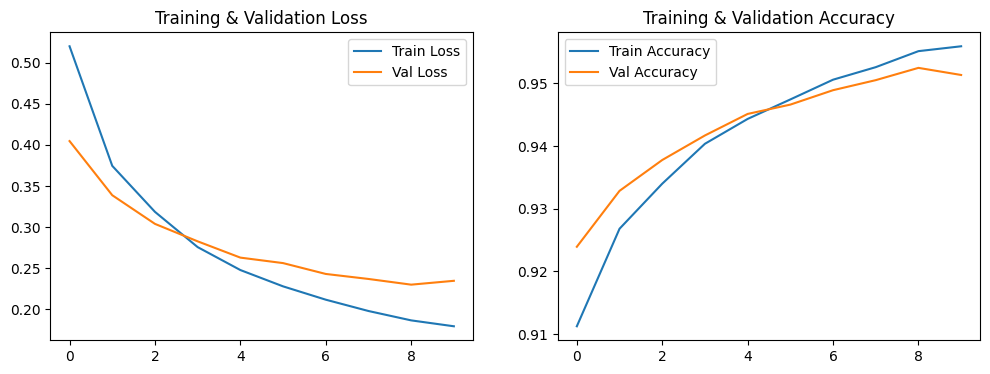

In [16]:
# ===========================================
# 5. Visualisasi Hasil Eksperimen 1
# ===========================================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

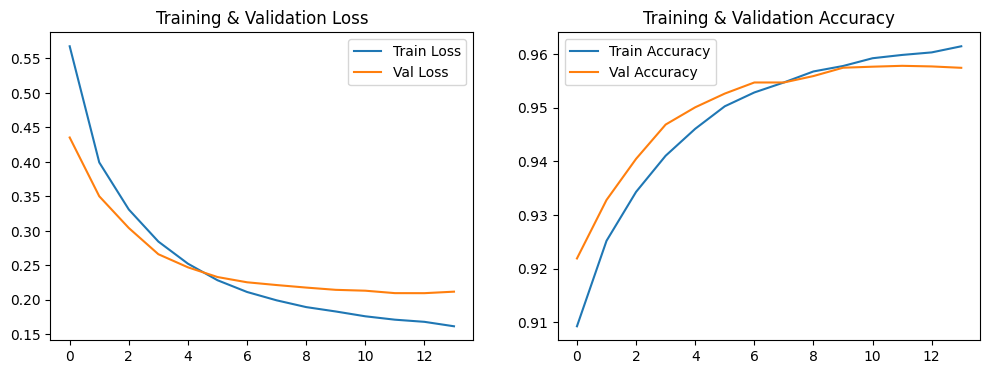

In [17]:
# ===========================================
# 5. Visualisasi Hasil Eksperimen 2
# ===========================================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

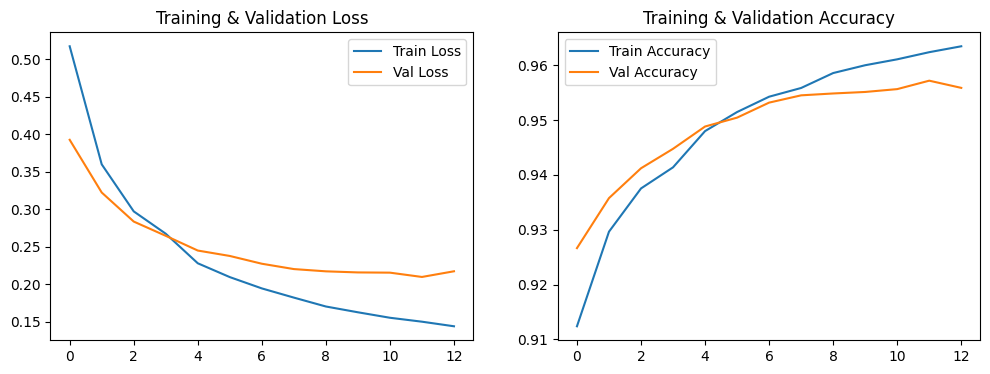

In [18]:
# ===========================================
# 5. Visualisasi Hasil Eksperimen 3
# ===========================================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

In [19]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │       131,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │       165,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, None, 500)      │        32,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 989,918 (3.78 MB)

 Trainable params: 329,972 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 659,946 (2.52 MB)

In [20]:
transformer2.summary()

Model: "transformer_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)             │ ?                      │        58,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │        66,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, None, 500)      │        16,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,518 (1.62 MB)

 Trainable params: 141,172 (551.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 282,346 (1.08 MB)

In [21]:
transformer3.summary()

Model: "transformer_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_2 (Encoder)             │ ?                      │        98,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Decoder)             │ ?                      │       132,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, None, 500)      │        32,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 791,774 (3.02 MB)

 Trainable params: 263,924 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 527,850 (2.01 MB)

In [22]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import tensorflow as tf # Asumsikan Anda menggunakan TensorFlow/Keras

# Inisialisasi SmoothingFunction untuk mengatasi kasus n-gram tidak ada
chencherry = SmoothingFunction()

# Fungsi untuk menghitung BLEU score untuk satu pasangan kalimat
def calculate_bleu_for_pair(reference_text, candidate_text):
    """
    Menghitung BLEU score untuk satu pasangan kalimat referensi dan kandidat.
    Keduanya harus berupa string.
    """
    # Tokenisasi kalimat menjadi list of words (sesuaikan jika tokenizer Anda berbeda)
    reference_tokens = [reference_text.split()] # sentence_bleu mengharapkan list of lists of tokens
    candidate_tokens = candidate_text.split()

    # Hitung BLEU score, umum menggunakan hingga 4-gram (bobot default)
    # Smoothing function 'method1' (atau chencherry.method1) adalah pilihan umum
    score = sentence_bleu(reference_tokens, candidate_tokens, smoothing_function=chencherry.method1)
    return score

# Fungsi untuk mendapatkan prediksi teks dari model
# (Mirip dengan fungsi normalize_text Anda, tetapi mungkin disederhanakan untuk evaluasi)
def predict_text(input_text, model, src_tokenizer, tgt_tokenizer, max_length):
    # Tokenisasi input
    processed_src = src_tokenizer([input_text])

    # Encode input menggunakan encoder
    encoder_output = model.encoder(processed_src, training=False)

    # Inisialisasi decoder dengan token [start]
    start_token_index = tgt_tokenizer.get_vocabulary().index('[start]')
    end_token_index = tgt_tokenizer.get_vocabulary().index('[end]')
    decoder_input = tf.expand_dims([start_token_index], 0)

    # Generate token step-by-step
    for _ in range(max_length):
        enc_padding_mask, combined_mask, enc_dec_padding_mask = model.create_masks(
            processed_src, decoder_input
        )

        predictions = model.decoder(
            decoder_input, encoder_output, training=False,
            look_ahead_mask=combined_mask,
            padding_mask=enc_dec_padding_mask
        )
        predictions = model.final_layer(predictions)
        predicted_id = tf.argmax(predictions[:, -1, :], axis=-1)
        decoder_input = tf.concat([decoder_input, [predicted_id]], axis=-1)
        if predicted_id == end_token_index:
            break

    # Konversi token IDs ke teks
    generated_ids = decoder_input.numpy()[0]
    generated_tokens = [tgt_tokenizer.get_vocabulary()[i] for i in generated_ids
                        if i not in [start_token_index, end_token_index, 0]] # 0 adalah ID padding default
    return ' '.join(generated_tokens)

from sklearn.model_selection import train_test_split

# Preprocessing dasar seperti yang Anda lakukan sebelumnya
df_eval = df.copy() # Gunakan salinan untuk evaluasi
df_eval['slang_processed'] = df_eval['slang'].str.lower().str.replace('[^\\w\\s]', '', regex=True)
df_eval['formal_processed'] = df_eval['formal'].str.lower().str.replace('[^\\w\\s]', '', regex=True)

# Pisahkan data evaluasi dengan random_state yang sama seperti saat training
_, eval_df = train_test_split(df_eval, test_size=0.2, random_state=42)

raw_src_val_list = eval_df['slang_processed'].tolist()
cleaned_references = eval_df['formal_processed'].tolist()

In [23]:
# Hitung BLEU untuk setiap pasangan (Eksperimen 1)
bleu_scores = []
num_samples_to_evaluate = len(raw_src_val_list) # atau batasi jika terlalu banyak, misal 100

print(f"Mengevaluasi BLEU score untuk {num_samples_to_evaluate} sampel...")

for i in range(num_samples_to_evaluate):
    input_slang = raw_src_val_list[i]
    reference_formal = cleaned_references[i]

    # Dapatkan prediksi dari model Anda
    # MAX_SEQ_LENGTH + 2 karena tgt_tokenizer memiliki output_sequence_length tersebut
    # dan fungsi predict_text menggunakan max_length untuk loop generasinya
    predicted_formal = predict_text(input_slang, transformer, src_tokenizer, tgt_tokenizer, MAX_SEQ_LENGTH + 2)

    # Hitung BLEU score untuk pasangan ini
    pair_bleu_score = calculate_bleu_for_pair(reference_formal, predicted_formal)
    bleu_scores.append(pair_bleu_score)

    if (i + 1) % 50 == 0: # Cetak progres setiap 50 sampel
        print(f"Selesai {i + 1}/{num_samples_to_evaluate} sampel. BLEU sejauh ini: {np.mean(bleu_scores):.4f}")


# Rata-rata BLEU score di seluruh validation set
if bleu_scores:
    average_bleu_score = np.mean(bleu_scores)
    print(f"\nRata-rata BLEU Score pada {num_samples_to_evaluate} sampel validasi: {average_bleu_score:.4f}")
else:
    print("Tidak ada skor BLEU yang dihitung.")

# Contoh output individu untuk beberapa sampel pertama (opsional, untuk debugging)
print("\nContoh hasil individu:")
for i in range(min(5, num_samples_to_evaluate)):
    input_slang = raw_src_val_list[i]
    reference_formal = cleaned_references[i]
    predicted_formal = predict_text(input_slang, transformer, src_tokenizer, tgt_tokenizer, MAX_SEQ_LENGTH + 2)
    print(f"Input Slang    : {input_slang}")
    print(f"Ref. Formal    : {reference_formal}")
    print(f"Pred. Formal   : {predicted_formal}")
    print(f"BLEU           : {bleu_scores[i]:.4f}\n")

Mengevaluasi BLEU score untuk 950 sampel...
Selesai 50/950 sampel. BLEU sejauh ini: 0.2197
Selesai 100/950 sampel. BLEU sejauh ini: 0.1842
Selesai 150/950 sampel. BLEU sejauh ini: 0.1861
Selesai 200/950 sampel. BLEU sejauh ini: 0.1820
Selesai 250/950 sampel. BLEU sejauh ini: 0.1746
Selesai 300/950 sampel. BLEU sejauh ini: 0.1703
Selesai 350/950 sampel. BLEU sejauh ini: 0.1746
Selesai 400/950 sampel. BLEU sejauh ini: 0.1750
Selesai 450/950 sampel. BLEU sejauh ini: 0.1761
Selesai 500/950 sampel. BLEU sejauh ini: 0.1742
Selesai 550/950 sampel. BLEU sejauh ini: 0.1747
Selesai 600/950 sampel. BLEU sejauh ini: 0.1734
Selesai 650/950 sampel. BLEU sejauh ini: 0.1760
Selesai 700/950 sampel. BLEU sejauh ini: 0.1784
Selesai 750/950 sampel. BLEU sejauh ini: 0.1809
Selesai 800/950 sampel. BLEU sejauh ini: 0.1823
Selesai 850/950 sampel. BLEU sejauh ini: 0.1807
Selesai 900/950 sampel. BLEU sejauh ini: 0.1787
Selesai 950/950 sampel. BLEU sejauh ini: 0.1809

Rata-rata BLEU Score pada 950 sampel validas

In [24]:
# Hitung BLEU untuk setiap pasangan (Eksperimen 2)
bleu_scores = []
num_samples_to_evaluate = len(raw_src_val_list) # atau batasi jika terlalu banyak, misal 100

print(f"Mengevaluasi BLEU score untuk {num_samples_to_evaluate} sampel...")

for i in range(num_samples_to_evaluate):
    input_slang = raw_src_val_list[i]
    reference_formal = cleaned_references[i]

    # Dapatkan prediksi dari model Anda
    # MAX_SEQ_LENGTH + 2 karena tgt_tokenizer memiliki output_sequence_length tersebut
    # dan fungsi predict_text menggunakan max_length untuk loop generasinya
    predicted_formal = predict_text(input_slang, transformer2, src_tokenizer, tgt_tokenizer, MAX_SEQ_LENGTH + 2)

    # Hitung BLEU score untuk pasangan ini
    pair_bleu_score = calculate_bleu_for_pair(reference_formal, predicted_formal)
    bleu_scores.append(pair_bleu_score)

    if (i + 1) % 50 == 0: # Cetak progres setiap 50 sampel
        print(f"Selesai {i + 1}/{num_samples_to_evaluate} sampel. BLEU sejauh ini: {np.mean(bleu_scores):.4f}")


# Rata-rata BLEU score di seluruh validation set
if bleu_scores:
    average_bleu_score = np.mean(bleu_scores)
    print(f"\nRata-rata BLEU Score pada {num_samples_to_evaluate} sampel validasi: {average_bleu_score:.4f}")
else:
    print("Tidak ada skor BLEU yang dihitung.")

# Contoh output individu untuk beberapa sampel pertama (opsional, untuk debugging)
print("\nContoh hasil individu:")
for i in range(min(5, num_samples_to_evaluate)):
    input_slang = raw_src_val_list[i]
    reference_formal = cleaned_references[i]
    predicted_formal = predict_text(input_slang, transformer2, src_tokenizer, tgt_tokenizer, MAX_SEQ_LENGTH + 2)
    print(f"Input Slang    : {input_slang}")
    print(f"Ref. Formal    : {reference_formal}")
    print(f"Pred. Formal   : {predicted_formal}")
    print(f"BLEU           : {bleu_scores[i]:.4f}\n")

Mengevaluasi BLEU score untuk 950 sampel...
Selesai 50/950 sampel. BLEU sejauh ini: 0.2330
Selesai 100/950 sampel. BLEU sejauh ini: 0.2202
Selesai 150/950 sampel. BLEU sejauh ini: 0.2103
Selesai 200/950 sampel. BLEU sejauh ini: 0.2151
Selesai 250/950 sampel. BLEU sejauh ini: 0.2084
Selesai 300/950 sampel. BLEU sejauh ini: 0.2032
Selesai 350/950 sampel. BLEU sejauh ini: 0.2078
Selesai 400/950 sampel. BLEU sejauh ini: 0.2069
Selesai 450/950 sampel. BLEU sejauh ini: 0.2065
Selesai 500/950 sampel. BLEU sejauh ini: 0.2025
Selesai 550/950 sampel. BLEU sejauh ini: 0.1995
Selesai 600/950 sampel. BLEU sejauh ini: 0.1981
Selesai 650/950 sampel. BLEU sejauh ini: 0.1981
Selesai 700/950 sampel. BLEU sejauh ini: 0.2000
Selesai 750/950 sampel. BLEU sejauh ini: 0.2027
Selesai 800/950 sampel. BLEU sejauh ini: 0.2033
Selesai 850/950 sampel. BLEU sejauh ini: 0.2017
Selesai 900/950 sampel. BLEU sejauh ini: 0.2004
Selesai 950/950 sampel. BLEU sejauh ini: 0.2018

Rata-rata BLEU Score pada 950 sampel validas

In [25]:
# Hitung BLEU untuk setiap pasangan (Eksperimen 2)
bleu_scores = []
num_samples_to_evaluate = len(raw_src_val_list) # atau batasi jika terlalu banyak, misal 100

print(f"Mengevaluasi BLEU score untuk {num_samples_to_evaluate} sampel...")

for i in range(num_samples_to_evaluate):
    input_slang = raw_src_val_list[i]
    reference_formal = cleaned_references[i]

    # Dapatkan prediksi dari model Anda
    # MAX_SEQ_LENGTH + 2 karena tgt_tokenizer memiliki output_sequence_length tersebut
    # dan fungsi predict_text menggunakan max_length untuk loop generasinya
    predicted_formal = predict_text(input_slang, transformer3, src_tokenizer, tgt_tokenizer, MAX_SEQ_LENGTH + 2)

    # Hitung BLEU score untuk pasangan ini
    pair_bleu_score = calculate_bleu_for_pair(reference_formal, predicted_formal)
    bleu_scores.append(pair_bleu_score)

    if (i + 1) % 50 == 0: # Cetak progres setiap 50 sampel
        print(f"Selesai {i + 1}/{num_samples_to_evaluate} sampel. BLEU sejauh ini: {np.mean(bleu_scores):.4f}")


# Rata-rata BLEU score di seluruh validation set
if bleu_scores:
    average_bleu_score = np.mean(bleu_scores)
    print(f"\nRata-rata BLEU Score pada {num_samples_to_evaluate} sampel validasi: {average_bleu_score:.4f}")
else:
    print("Tidak ada skor BLEU yang dihitung.")

# Contoh output individu untuk beberapa sampel pertama (opsional, untuk debugging)
print("\nContoh hasil individu:")
for i in range(min(5, num_samples_to_evaluate)):
    input_slang = raw_src_val_list[i]
    reference_formal = cleaned_references[i]
    predicted_formal = predict_text(input_slang, transformer3, src_tokenizer, tgt_tokenizer, MAX_SEQ_LENGTH + 2)
    print(f"Input Slang    : {input_slang}")
    print(f"Ref. Formal    : {reference_formal}")
    print(f"Pred. Formal   : {predicted_formal}")
    print(f"BLEU           : {bleu_scores[i]:.4f}\n")

Mengevaluasi BLEU score untuk 950 sampel...
Selesai 50/950 sampel. BLEU sejauh ini: 0.2225
Selesai 100/950 sampel. BLEU sejauh ini: 0.2134
Selesai 150/950 sampel. BLEU sejauh ini: 0.2098
Selesai 200/950 sampel. BLEU sejauh ini: 0.2165
Selesai 250/950 sampel. BLEU sejauh ini: 0.2049
Selesai 300/950 sampel. BLEU sejauh ini: 0.1989
Selesai 350/950 sampel. BLEU sejauh ini: 0.2026
Selesai 400/950 sampel. BLEU sejauh ini: 0.2020
Selesai 450/950 sampel. BLEU sejauh ini: 0.2009
Selesai 500/950 sampel. BLEU sejauh ini: 0.1970
Selesai 550/950 sampel. BLEU sejauh ini: 0.1956
Selesai 600/950 sampel. BLEU sejauh ini: 0.1934
Selesai 650/950 sampel. BLEU sejauh ini: 0.1942
Selesai 700/950 sampel. BLEU sejauh ini: 0.1970
Selesai 750/950 sampel. BLEU sejauh ini: 0.2012
Selesai 800/950 sampel. BLEU sejauh ini: 0.2039
Selesai 850/950 sampel. BLEU sejauh ini: 0.2035
Selesai 900/950 sampel. BLEU sejauh ini: 0.2017
Selesai 950/950 sampel. BLEU sejauh ini: 0.2025

Rata-rata BLEU Score pada 950 sampel validas